In [52]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm as tqdm

# Define Classes and Functions

## Class: Maze

In [9]:
class Maze:
    
    
    '''
    Maze class as defined in Example 8.1: Dyna Maze, Section 8.2 of RL_Sutton
    '''

    def __init__(self):
        
        self.WORLD_WIDTH = 9 # maze width
        self.WORLD_HEIGHT = 6 # maze height

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        self.START_STATE = [2, 0] # start state
        self.GOAL_STATES = [[0, 8]] # goal state

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
#         self.oldObstacles = None
#         self.newObstacles = None

#         # time to change obstacles
#         self.changingPoint = None

        # initial state-action pair values
        self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # max steps
        self.maxSteps = float('inf')

#         # track the resolution for this maze
#         self.resolution = 1

    # take @action in @state
    # @return: [new state, reward]
    def takeAction(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward
    
#     # extend a state to a higher resolution maze
#     # @state: state in lower resoultion maze
#     # @factor: extension factor, one state will become factor^2 states after extension
#     def extendState(self, state, factor):
#         newState = [state[0] * factor, state[1] * factor]
#         newStates = []
#         for i in range(0, factor):
#             for j in range(0, factor):
#                 newStates.append([newState[0] + i, newState[1] + j])
#         return newStates

#     # extend a state into higher resolution
#     # one state in original maze will become @factor^2 states in @return new maze
#     def extendMaze(self, factor):
#         newMaze = Maze()
#         newMaze.WORLD_WIDTH = self.WORLD_WIDTH * factor
#         newMaze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
#         newMaze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
#         newMaze.GOAL_STATES = self.extendState(self.GOAL_STATES[0], factor)
#         newMaze.obstacles = []
#         for state in self.obstacles:
#             newMaze.obstacles.extend(self.extendState(state, factor))
#         newMaze.stateActionValues = np.zeros((newMaze.WORLD_HEIGHT, newMaze.WORLD_WIDTH, len(newMaze.actions)))
#         newMaze.resolution = factor
#         return newMaze    

## Class: DynaParams

In [10]:
class DynaParams:
    
    '''
    Wrapper Class for parameters of dyna algorithms
    '''

    def __init__(self):
        
        self.gamma = 0.95 # discount
        self.epsilon = 0.1 # probability for exploration
        self.alpha = 0.1 # step size
        self.planningSteps = 5 # n-step planning
        self.runs = 10 # average over several independent runs
        self.methods = ['Dyna-Q', 'Dyna-Q+'] # algorithm names
        
#         self.theta = 0 # threshold for priority queue
#         self.timeWeight = 0 # weight for elapsed time     

## Class: chooseAction

In [11]:
def chooseAction(state, stateActionValues, maze, dynaParams):
    '''
    # choose an action based on epsilon-greedy algorithm
    '''
    if np.random.binomial(1, dynaParams.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = stateActionValues[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

## Class: TrivialModel

In [12]:
class TrivialModel:
    
    '''
    # Trivial model for planning in Dyna-Q
    '''

    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand = np.random):
        self.model = dict() # Initialize model as a dict
        self.rand = rand # Initialize random state

    # feed the model with previous experience
    def feed(self, currentState, action, newState, reward):
        if tuple(currentState) not in self.model.keys():
            self.model[tuple(currentState)] = dict()
        self.model[tuple(currentState)][action] = [list(newState), reward]

    # randomly sample from previous experience
    def sample(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        state = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[state].keys())))
        action = list(self.model[state])[actionIndex]
        newState, reward = self.model[state][action]
        return list(state), action, list(newState), reward

## Class: dynaQ

In [37]:
# play for an episode for Dyna-Q algorithm
# @stateActionValues: state action pair values, will be updated
# @model: model instance for planning
# @planningSteps: steps for planning
# @maze: a maze instance containing all information about the environment
# @dynaParams: several params for the algorithm
def dynaQ(stateActionValues, model, maze, dynaParams):
    currentState = maze.START_STATE
    steps = 0
    while currentState not in maze.GOAL_STATES: # Loop until goal state is reached
        steps += 1 # Update steps taken till now
        action = chooseAction(currentState, stateActionValues, maze, dynaParams) # Choose action based on eps-greedy policy
        newState, reward = maze.takeAction(currentState, action) # take action

        # Q-Learning update
        stateActionValues[currentState[0], currentState[1], action] += \
            dynaParams.alpha * (reward + dynaParams.gamma * np.max(stateActionValues[newState[0], newState[1], :]) -
            stateActionValues[currentState[0], currentState[1], action])

        # feed the model with experience
        model.feed(currentState, action, newState, reward)

        # sample experience from the model
        for t in range(0, dynaParams.planningSteps):
            stateSample, actionSample, newStateSample, rewardSample = model.sample()
            stateActionValues[stateSample[0], stateSample[1], actionSample] += \
                dynaParams.alpha * (rewardSample + dynaParams.gamma * np.max(stateActionValues[newStateSample[0],
                newStateSample[1], :]) - stateActionValues[stateSample[0], stateSample[1], actionSample])
               

        currentState = newState # Update currentState

        # check whether it has exceeded the step limit
        if steps > maze.maxSteps:
            break

    return steps

# Example 8.1: Dyna Maze

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.37s/it]


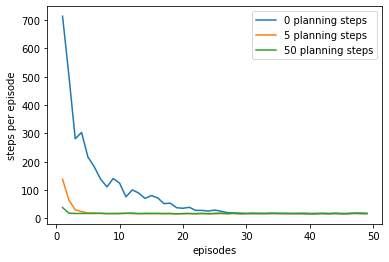

In [59]:
dynaMaze = Maze() # Instantiate Dyna Maze environment
dynaParams = DynaParams() # Define parameters of Dyna algorithm

planningSteps = [0, 5, 50] # Array of planning steps
episodes = 50 # Number of episodes to run
steps = np.zeros((len(planningSteps), episodes))
runs = 30 # Number of repetitions of the experiment

# this random seed is for sampling from model
# we do need this separate random seed to make sure the first episodes for all planning steps are the same
rand = np.random.RandomState(1)

for run in tqdm(range(0, runs)):
    for index, planningStep in enumerate(planningSteps):
        dynaParams.planningSteps = planningStep # Set current value of planningStep
        np.random.seed(run + 1) # set same random seed for each planning step
        currentStateActionValues = np.copy(dynaMaze.stateActionValues) # Initialize state-action values
        model = TrivialModel(rand) # generate an instance of Dyna-Q model
        for ep in range(0, episodes): # Run dynaQ for multiple episodes
            #print('run:', run, 'planning step:', planningStep, 'episode:', ep)
            steps[index, ep] += dynaQ(currentStateActionValues, model, dynaMaze, dynaParams)

steps /= runs # Averaged number of steps over runs

plt.figure(0)
for i in range(0, len(planningSteps)):
    plt.plot(range(1, episodes), steps[i, 1:], label=str(planningSteps[i]) + ' planning steps')
plt.xlabel('episodes')
plt.ylabel('steps per episode')
plt.legend();

In [ ]:
    episodes = 50
    planningSteps = [0, 5, 50]
    steps = np.zeros((len(planningSteps), episodes))

    # this random seed is for sampling from model
    # we do need this separate random seed to make sure the first episodes for all planning steps are the same
    rand = np.random.RandomState(0)

    for run in range(0, runs):
        for index, planningStep in zip(range(0, len(planningSteps)), planningSteps):
            dynaParams.planningSteps = planningStep

            # set same random seed for each planning step
            np.random.seed(run)

            currentStateActionValues = np.copy(dynaMaze.stateActionValues)

            # generate an instance of Dyna-Q model
            model = TrivialModel(rand)
            for ep in range(0, episodes):
                print('run:', run, 'planning step:', planningStep, 'episode:', ep)
                steps[index, ep] += dynaQ(currentStateActionValues, model, dynaMaze, dynaParams)

    # averaging over runs
    steps /= runs

    plt.figure(0)
    for i in range(0, len(planningSteps)):
        plt.plot(range(0, episodes), steps[i, :], label=str(planningSteps[i]) + ' planning steps')
    plt.xlabel('episodes')
    plt.ylabel('steps per episode')
    plt.legend()

# Backup

## Test Environment

In [4]:
dynaMaze = Maze()
print("Maze_Width: ", dynaMaze.WORLD_WIDTH)
print("Maze_Height: ", dynaMaze.WORLD_HEIGHT)
print("Maze_Actions: ", dynaMaze.actions)
print("Maze_Start_State: ", dynaMaze.START_STATE)
print("Maze_Goal_States: ", dynaMaze.GOAL_STATES)
print("Maze_obstacles: ", dynaMaze.obstacles)
print("Maze_stateActionValues_Shape: ", dynaMaze.stateActionValues.shape)

Maze_Width:  9
Maze_Height:  6
Maze_Actions:  [0, 1, 2, 3]
Maze_Start_State:  [2, 0]
Maze_Goal_States:  [[0, 8]]
Maze_obstacles:  [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
Maze_stateActionValues_Shape:  (6, 9, 4)


## Reference Code

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import itertools
import heapq

class PriorityQueue:
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.REMOVED = '<removed-task>'
        self.counter = itertools.count()

    def addItem(self, item, priority=0):
        if item in self.entry_finder:
            self.removeItem(item)
        count = next(self.counter)
        entry = [priority, count, item]
        self.entry_finder[item] = entry
        heapq.heappush(self.pq, entry)

    def removeItem(self, item):
        entry = self.entry_finder.pop(item)
        entry[-1] = self.REMOVED

    def popTask(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item is not self.REMOVED:
                del self.entry_finder[item]
                return item, priority
        raise KeyError('pop from an empty priority queue')

    def empty(self):
        return not self.entry_finder

# choose an action based on epsilon-greedy algorithm
def chooseAction(state, stateActionValues, maze, dynaParams):
    if np.random.binomial(1, dynaParams.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        values = stateActionValues[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

# Time-based model for planning in Dyna-Q+
class TimeModel:

    # @maze: the maze instance. Indeed it's not very reasonable to give access to maze to the model.
    # @timeWeight: also called kappa, the weight for elapsed time in sampling reward, it need to be small
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, maze, timeWeight=1e-4, rand=np.random):
        self.rand = rand
        self.model = dict()

        # track the total time
        self.time = 0

        self.timeWeight = timeWeight
        self.maze = maze

    # feed the model with previous experience
    def feed(self, currentState, action, newState, reward):
        self.time += 1
        if tuple(currentState) not in self.model.keys():
            self.model[tuple(currentState)] = dict()

            # Actions that had never been tried before from a state were allowed to be considered in the planning step
            for action_ in self.maze.actions:
                if action_ != action:
                    # Such actions would lead back to the same state with a reward of zero
                    # Notice that the minimum time stamp is 1 instead of 0
                    self.model[tuple(currentState)][action_] = [list(currentState), 0, 1]

        self.model[tuple(currentState)][action] = [list(newState), reward, self.time]

    # randomly sample from previous experience
    def sample(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        state = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[state].keys())))
        action = list(self.model[state])[actionIndex]
        newState, reward, time = self.model[state][action]

        # adjust reward with elapsed time since last vist
        reward += self.timeWeight * np.sqrt(self.time - time)

        return list(state), action, list(newState), reward

# Model containing a priority queue for Prioritized Sweeping
class PriorityModel(TrivialModel):

    def __init__(self, rand=np.random):
        TrivialModel.__init__(self, rand)
        # maintain a priority queue
        self.priorityQueue = PriorityQueue()
        # track predecessors for every state
        self.predecessors = dict()

    # add a @state-@action pair into the priority queue with priority @priority
    def insert(self, priority, state, action):
        # note the priority queue is a minimum heap, so we use -priority
        self.priorityQueue.addItem((tuple(state), action), -priority)

    # @return: whether the priority queue is empty
    def empty(self):
        return self.priorityQueue.empty()

    # get the first item in the priority queue
    def sample(self):
        (state, action), priority = self.priorityQueue.popTask()
        newState, reward = self.model[state][action]
        return -priority, list(state), action, list(newState), reward

    # feed the model with previous experience
    def feed(self, currentState, action, newState, reward):
        TrivialModel.feed(self, currentState, action, newState, reward)
        if tuple(newState) not in self.predecessors.keys():
            self.predecessors[tuple(newState)] = set()
        self.predecessors[tuple(newState)].add((tuple(currentState), action))

    # get all seen predecessors of a state @state
    def predecessor(self, state):
        if tuple(state) not in self.predecessors.keys():
            return []
        predecessors = []
        for statePre, actionPre in list(self.predecessors[tuple(state)]):
            predecessors.append([list(statePre), actionPre, self.model[statePre][actionPre][1]])
        return predecessors


# play for an episode for Dyna-Q algorithm
# @stateActionValues: state action pair values, will be updated
# @model: model instance for planning
# @planningSteps: steps for planning
# @maze: a maze instance containing all information about the environment
# @dynaParams: several params for the algorithm
def dynaQ(stateActionValues, model, maze, dynaParams):
    currentState = maze.START_STATE
    steps = 0
    while currentState not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = chooseAction(currentState, stateActionValues, maze, dynaParams)

        # take action
        newState, reward = maze.takeAction(currentState, action)

        # Q-Learning update
        stateActionValues[currentState[0], currentState[1], action] += \
            dynaParams.alpha * (reward + dynaParams.gamma * np.max(stateActionValues[newState[0], newState[1], :]) -
            stateActionValues[currentState[0], currentState[1], action])

        # feed the model with experience
        model.feed(currentState, action, newState, reward)

        # sample experience from the model
        for t in range(0, dynaParams.planningSteps):
            stateSample, actionSample, newStateSample, rewardSample = model.sample()
            stateActionValues[stateSample[0], stateSample[1], actionSample] += \
                dynaParams.alpha * (rewardSample + dynaParams.gamma * np.max(stateActionValues[newStateSample[0], newStateSample[1], :]) -
                stateActionValues[stateSample[0], stateSample[1], actionSample])

        currentState = newState

        # check whether it has exceeded the step limit
        if steps > maze.maxSteps:
            break

    return steps

# play for an episode for prioritized sweeping algorithm
# @stateActionValues: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dynaParams: several params for the algorithm
# @return: # of backups happened in planning phase in this episode
def prioritizedSweeping(stateActionValues, model, maze, dynaParams):
    currentState = maze.START_STATE

    # track the steps in this episode
    steps = 0

    # track the backups in planning phase
    backups = 0

    while currentState not in maze.GOAL_STATES:
        steps += 1

        # get action
        action = chooseAction(currentState, stateActionValues, maze, dynaParams)

        # take action
        newState, reward = maze.takeAction(currentState, action)

        # feed the model with experience
        model.feed(currentState, action, newState, reward)

        # get the priority for current state action pair
        priority = np.abs(reward + dynaParams.gamma * np.max(stateActionValues[newState[0], newState[1], :]) -
                          stateActionValues[currentState[0], currentState[1], action])

        if priority > dynaParams.theta:
            model.insert(priority, currentState, action)

        # start planning
        planningStep = 0

        # planning for several steps,
        # although keep planning until the priority queue becomes empty will converge much faster
        while planningStep < dynaParams.planningSteps and not model.empty():
            # get a sample with highest priority from the model
            priority, sampleState, sampleAction, sampleNewState, sampleReward = model.sample()

            # update the state action value for the sample
            delta = sampleReward + dynaParams.gamma * np.max(stateActionValues[sampleNewState[0], sampleNewState[1], :]) - \
                    stateActionValues[sampleState[0], sampleState[1], sampleAction]
            stateActionValues[sampleState[0], sampleState[1], sampleAction] += dynaParams.alpha * delta

            # deal with all the predecessors of the sample state
            for statePre, actionPre, rewardPre in model.predecessor(sampleState):
                priority = np.abs(rewardPre + dynaParams.gamma * np.max(stateActionValues[sampleState[0], sampleState[1], :]) -
                                  stateActionValues[statePre[0], statePre[1], actionPre])
                if priority > dynaParams.theta:
                    model.insert(priority, statePre, actionPre)
            planningStep += 1

        currentState = newState

        # update the # of backups
        backups += planningStep

    return backups

# Figure 8.3, DynaMaze, use 10 runs instead of 30 runs
def figure8_3():

    # set up an instance for DynaMaze
    dynaMaze = Maze()
    dynaParams = DynaParams()

    runs = 10
    episodes = 50
    planningSteps = [0, 5, 50]
    steps = np.zeros((len(planningSteps), episodes))

    # this random seed is for sampling from model
    # we do need this separate random seed to make sure the first episodes for all planning steps are the same
    rand = np.random.RandomState(0)

    for run in range(0, runs):
        for index, planningStep in zip(range(0, len(planningSteps)), planningSteps):
            dynaParams.planningSteps = planningStep

            # set same random seed for each planning step
            np.random.seed(run)

            currentStateActionValues = np.copy(dynaMaze.stateActionValues)

            # generate an instance of Dyna-Q model
            model = TrivialModel(rand)
            for ep in range(0, episodes):
                print('run:', run, 'planning step:', planningStep, 'episode:', ep)
                steps[index, ep] += dynaQ(currentStateActionValues, model, dynaMaze, dynaParams)

    # averaging over runs
    steps /= runs

    plt.figure(0)
    for i in range(0, len(planningSteps)):
        plt.plot(range(0, episodes), steps[i, :], label=str(planningSteps[i]) + ' planning steps')
    plt.xlabel('episodes')
    plt.ylabel('steps per episode')
    plt.legend()

# wrapper function for changing maze
# @maze: a maze instance
# @dynaParams: several parameters for dyna algorithms
def changingMaze(maze, dynaParams):

    # set up max steps
    maxSteps = maze.maxSteps

    # track the cumulative rewards
    rewards = np.zeros((2, maxSteps))

    for run in range(0, dynaParams.runs):
        # set up models
        models = [TrivialModel(), TimeModel(maze, timeWeight=dynaParams.timeWeight)]

        # track cumulative reward in current run
        rewards_ = np.zeros((2, maxSteps))

        # initialize state action values
        stateActionValues = [np.copy(maze.stateActionValues), np.copy(maze.stateActionValues)]

        for i in range(0, len(dynaParams.methods)):
            print('run:', run, dynaParams.methods[i])

            # set old obstacles for the maze
            maze.obstacles = maze.oldObstacles

            steps = 0
            lastSteps = steps
            while steps < maxSteps:
                # play for an episode
                steps += dynaQ(stateActionValues[i], models[i], maze, dynaParams)

                # update cumulative rewards
                steps_ = min(steps, maxSteps - 1)
                rewards_[i, lastSteps: steps_] = rewards_[i, lastSteps]
                rewards_[i, steps_] = rewards_[i, lastSteps] + 1
                lastSteps = steps

                if steps > maze.changingPoint:
                    # change the obstacles
                    maze.obstacles = maze.newObstacles
        rewards += rewards_

    # averaging over runs
    rewards /= dynaParams.runs

    return rewards

# Figure 8.5, BlockingMaze
def figure8_5():
    # set up a blocking maze instance
    blockingMaze = Maze()
    blockingMaze.START_STATE = [5, 3]
    blockingMaze.GOAL_STATES = [[0, 8]]
    blockingMaze.oldObstacles = [[3, i] for i in range(0, 8)]

    # new obstalces will block the optimal path
    blockingMaze.newObstacles = [[3, i] for i in range(1, 9)]

    # step limit
    blockingMaze.maxSteps = 3000

    # obstacles will change after 1000 steps
    # the exact step for changing will be different
    # However given that 1000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    blockingMaze.changingPoint = 1000

    # set up parameters
    dynaParams = DynaParams()

    # it's a tricky alpha ...
    dynaParams.alpha = 0.7

    # 5-step planning
    dynaParams.planningSteps = 5

    # average over 20 runs
    dynaParams.runs = 20

    # kappa must be small, as the reward for getting the goal is only 1
    dynaParams.timeWeight = 1e-4

    # play
    rewards = changingMaze(blockingMaze, dynaParams)

    plt.figure(1)
    for i in range(0, len(dynaParams.methods)):
        plt.plot(range(0, blockingMaze.maxSteps), rewards[i, :], label=dynaParams.methods[i])
    plt.xlabel('time steps')
    plt.ylabel('cumulative reward')
    plt.legend()

# Figure 8.6, ShortcutMaze
def figure8_6():
    # set up a shortcut maze instance
    shortcutMaze = Maze()
    shortcutMaze.START_STATE = [5, 3]
    shortcutMaze.GOAL_STATES = [[0, 8]]
    shortcutMaze.oldObstacles = [[3, i] for i in range(1, 9)]

    # new obstacles will have a shorter path
    shortcutMaze.newObstacles = [[3, i] for i in range(1, 8)]

    # step limit
    shortcutMaze.maxSteps = 6000

    # obstacles will change after 3000 steps
    # the exact step for changing will be different
    # However given that 3000 steps is long enough for both algorithms to converge,
    # the difference is guaranteed to be very small
    shortcutMaze.changingPoint = 3000

    # set up parameters
    dynaParams = DynaParams()

    # 50-step planning
    dynaParams.planningSteps = 50

    # average over 5 independent runs
    dynaParams.runs = 5

    # weight for elapsed time sine last visit
    dynaParams.timeWeight = 1e-3

    # also a tricky alpha ...
    dynaParams.alpha = 0.7

    # play
    rewards = changingMaze(shortcutMaze, dynaParams)

    plt.figure(2)
    for i in range(0, len(dynaParams.methods)):
        plt.plot(range(0, shortcutMaze.maxSteps), rewards[i, :], label=dynaParams.methods[i])
    plt.xlabel('time steps')
    plt.ylabel('cumulative reward')
    plt.legend()

# Helper function to display best actions, just for debug
def printActions(stateActionValues, maze):
    bestActions = []
    for i in range(0, maze.WORLD_HEIGHT):
        bestActions.append([])
        for j in range(0, maze.WORLD_WIDTH):
            if [i, j] in maze.GOAL_STATES:
                bestActions[-1].append('G')
                continue
            if [i, j] in maze.obstacles:
                bestActions[-1].append('X')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == maze.ACTION_UP:
                bestActions[-1].append('U')
            if bestAction == maze.ACTION_DOWN:
                bestActions[-1].append('D')
            if bestAction == maze.ACTION_LEFT:
                bestActions[-1].append('L')
            if bestAction == maze.ACTION_RIGHT:
                bestActions[-1].append('R')
    for row in bestActions:
        print(row)
    print('')

# Check whether state-action values are already optimal
def checkPath(stateActionValues, maze):
    # get the length of optimal path
    # 14 is the length of optimal path of the original maze
    # 1.2 means it's a relaxed optifmal path
    maxSteps = 14 * maze.resolution * 1.2
    currentState = maze.START_STATE
    steps = 0
    while currentState not in maze.GOAL_STATES:
        bestAction = np.argmax(stateActionValues[currentState[0], currentState[1], :])
        currentState, _ = maze.takeAction(currentState, bestAction)
        steps += 1
        if steps > maxSteps:
            return False
    return True

# Figure 8.7, mazes with different resolution
def figure8_7():
    # get the original 6 * 9 maze
    originalMaze = Maze()

    # set up the parameters for each algorithm
    paramsDyna = DynaParams()
    paramsDyna.planningSteps = 5
    paramsDyna.alpha = 0.5
    paramsDyna.gamma = 0.95

    paramsPrioritized = DynaParams()
    paramsPrioritized.theta = 0.0001
    paramsPrioritized.planningSteps = 5
    paramsPrioritized.alpha = 0.5
    paramsPrioritized.gamma = 0.95

    params = [paramsPrioritized, paramsDyna]

    # set up models for planning
    models = [PriorityModel, TrivialModel]
    methodNames = ['Prioritized Sweeping', 'Dyna-Q']

    # due to limitation of my machine, I can only perform experiments for 5 mazes
    # say 1st maze has w * h states, then k-th maze has w * h * k * k states
    numOfMazes = 5

    # build all the mazes
    mazes = [originalMaze.extendMaze(i) for i in range(1, numOfMazes + 1)]
    methods = [prioritizedSweeping, dynaQ]

    # track the # of backups
    backups = np.zeros((2, numOfMazes))

    # My machine cannot afford too many runs...
    runs = 5
    for run in range(0, runs):
        for i in range(0, len(methodNames)):
            for mazeIndex, maze in zip(range(0, len(mazes)), mazes):
                print('run:', run, methodNames[i], 'maze size:', maze.WORLD_HEIGHT * maze.WORLD_WIDTH)

                # initialize the state action values
                currentStateActionValues = np.copy(maze.stateActionValues)

                # track steps / backups for each episode
                steps = []

                # generate the model
                model = models[i]()

                # play for an episode
                while True:
                    steps.append(methods[i](currentStateActionValues, model, maze, params[i]))

                    # print best actions w.r.t. current state-action values
                    # printActions(currentStateActionValues, maze)

                    # check whether the (relaxed) optimal path is found
                    if checkPath(currentStateActionValues, maze):
                        break

                # update the total steps / backups for this maze
                backups[i][mazeIndex] += np.sum(steps)

    # Dyna-Q performs several backups per step
    backups[1, :] *= paramsDyna.planningSteps

    # average over independent runs
    backups /= float(runs)

    plt.figure(3)
    for i in range(0, len(methodNames)):
        plt.plot(np.arange(1, numOfMazes + 1), backups[i, :], label=methodNames[i])
    plt.xlabel('maze resolution factor')
    plt.ylabel('backups until optimal solution')
    plt.yscale('log')
    plt.legend()

figure8_3()
figure8_5()
figure8_6()
figure8_7()
plt.show()